In [1]:
%load_ext tensorboard
import os, sys
import datetime
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, ProgressBar
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score
dvc = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {dvc} device")

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


In [2]:
# Data sets for training W0 and training W1

class w0_dataset(Dataset):
    def __init__(self, T, R):
        super(w0_dataset, self).__init__()
        
        self.T = T
        self.R = R
        
    def __len__(self):
        return len(self.T)

    def __getitem__(self, idx):
        return self.T[idx], self.R[idx]
    
class w1_dataset(Dataset):
    def __init__(self, T0, R0, theta0, T1, R1, theta1):
        super(w1_dataset, self).__init__()
        
        self.T = np.concatenate([T0, T1])
        self.R = np.concatenate([R0, R1])
        self.theta = np.concatenate([theta0, theta1])
        self.label = np.concatenate([np.zeros((len(T0), 1)), np.ones((len(T1), 1))])
                
    def __len__(self):
        return len(self.T)

    def __getitem__(self, idx):
        return self.T[idx], self.R[idx], self.theta[idx], self.label[idx]

In [3]:
# Loss function (NLL)

class NLLLoss(nn.Module):

    def __init__(self, obs_data, bins, normalize=False, device="cpu"):
        super(NLLLoss, self).__init__()
        self.normalize = normalize
        self.dvc = device
        self.obs_data = torch.from_numpy(obs_data).float().to(self.dvc)
        self.bins = torch.from_numpy(bins).float().to(self.dvc)
        self.h_obs_data = torch.tensor([(torch.bucketize(self.obs_data, self.bins)==i).sum() for i in range(1, len(self.bins))]).to(self.dvc)
        self.y_obs_data = len(self.obs_data)
        
    def forward(self, R, weights, theta):
        h_R = None
        for i in range(1, len(self.bins)):
            h_R_i = torch.mul((torch.bucketize(R, self.bins)==i), weights).sum().reshape(1)
            h_R = torch.cat((h_R, h_R_i)) if h_R != None else h_R_i
        if self.normalize: h_R = h_R * self.y_obs_data / h_R.sum()
        log_gauss = torch.neg(torch.div(torch.pow(theta, 2), 2.))
        nll = torch.neg(torch.add(torch.sub(torch.mul(self.h_obs_data, torch.log(h_R)), h_R).sum(), log_gauss))
        return nll

class NLLLoss_2D(nn.Module):

    def __init__(self, obs_data, bins1, bins2, device="cpu"):
        super(NLLLoss_2D, self).__init__()
        self.dvc = device
        self.h_obs_data = np.array([[((np.digitize(obs_data[:,0], bins1)==i) * (np.digitize(obs_data[:,1], bins2)==j)).sum() for j in range(1, len(bins2))] for i in range(1, len(bins1))])
        self.bins1 = torch.from_numpy(bins1).float().to(self.dvc)
        self.bins2 = torch.from_numpy(bins2).float().to(self.dvc)
        self.y_obs_data = len(obs_data)
        
    def forward(self, R, weights, theta):
        nll = 0
        for i in range(1, len(self.bins1)):
            for j in range(1, len(self.bins2)):
                h_R_ij = torch.matmul(torch.transpose((torch.bucketize(R, self.bins1)==i).double()*weights.reshape(-1,1), 0, 1), (torch.bucketize(R, self.bins2)==j).double())[0,1]#.reshape(1,1)
                if h_R_ij > 0:
                    nll += self.h_obs_data[i-1, j-1]*torch.log(h_R_ij) - h_R_ij
        log_gauss = torch.neg(torch.div(torch.pow(theta, 2), 2.))
        nll = torch.neg(torch.add(nll, log_gauss))
        return nll
    
    
def roc_auc(input, target, weight=None):
    fpr, tpr, _ = roc_curve(target, input, sample_weight=weight)
    tpr, fpr = np.array(list(zip(*sorted(zip(tpr, fpr)))))
    return 1 - auc(tpr, fpr)

In [4]:
# All the networks (W0, W1 and theta)

class w0_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=False, std_params=None):
        super(w0_network, self).__init__()
            
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(1 if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, T):
        if self.std_params: T = (T-self.std_params[0])/self.std_params[1]
        logit = self.linear_relu_stack(T)
        if self.sigmoid:
            return logit / (1 - logit)
        else:
            return torch.exp(logit)
        
class w0_dummy(nn.Module):
    def __init__(self):
        super(w0_dummy, self).__init__()
        
    def forward(self, T):
        return 1
    
class w1RT_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=True, std_params=None, n_inputs=4, dropouts=[0, 0.1, 0, 0]):
        super(w1RT_network, self).__init__()
        
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        self.n_inputs = n_inputs
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(self.n_inputs if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes):
                self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
                self.linear_relu_stack.add_module(f"batchNorm_{i}", nn.BatchNorm1d(nodes[i]))
            if dropouts[i] > 0: self.linear_relu_stack.add_module(f"dropout_{i}", nn.Dropout(p=dropouts[i]))
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, T, R, theta):
        T = (T-self.std_params[0])/self.std_params[1]
        R = (R-self.std_params[2])/self.std_params[3]
        x = torch.cat([R, T, theta], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return logit / (1 - logit + 0.00000000000001)
        else:
            return torch.exp(logit)

class w1T_network(w1RT_network):
    def __init__(self, n_inputs=2, *args, **kwargs):
        super(w1T_network, self).__init__(n_inputs=n_inputs, *args, **kwargs)
        
    def forward(self, T, R, theta):
        T = (T-self.std_params[0])/self.std_params[1]
        x = torch.cat([T, theta], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return logit / (1 - logit + 0.00000000000001)
        else:
            return torch.exp(logit)
        
class w1_dummy(nn.Module):
    def __init__(self):
        super(w1_dummy, self).__init__()
        
    def forward(self, T, R, theta):
        return 1
    
class theta_module(nn.Module):
    def __init__(self, init_value=0.):
        super(theta_module, self).__init__()
        self.theta = nn.Parameter(torch.ones(1) * init_value)
        
    def forward(self):
        return self.theta

In [5]:
# training and testing utilities

class w1_trainer:
    def __init__(self, train_dataloader, val_dataloader, model_w1, loss_fn, optimizer, max_epoch=1000, patience=10):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model_w1 = model_w1
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.patience = patience
        
        print("===================== Model W1 =====================")
        print(model_w1)

        self.best_state = self.model_w1.state_dict()
        self.best_epoch = None
        self.best_val_loss = None
        self.i_try = 0
        self.epoch = 0
        self.size = len(train_dataloader.dataset)
        
    def backpropagation(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def train_step(self):
        self.model_w1.train()
        for batch, (T, R, theta, label) in enumerate(self.train_dataloader):
            T, R, theta, label = T.to(dvc), R.to(dvc), theta.to(dvc), label.to(dvc)

            W = self.model_w1(T, R, theta)
            logit = W/(W + 1)
            loss = self.loss_fn(logit, label.double())

            # Backpropagation
            self.backpropagation(loss)

            loss, current = loss.item(), (batch+1) * len(R)
            print("\r" + f"[Epoch {self.epoch:>3d}] [{current:>5d}/{self.size:>5d}] [Train_loss: {loss:>7f}]", end="")
        
    def eval_step(self, data_loader):
        self.model_w1.eval()
        Ws, logits, labels = None, None, None
        with torch.no_grad():
            for batch, (T, R, theta, label) in enumerate(data_loader):
                T, R, theta, label = T.to(dvc), R.to(dvc), theta.to(dvc), label.to(dvc)

                W = self.model_w1(T, R, theta)
                Ws = torch.cat([Ws, W]) if Ws is not None else W
                labels = torch.cat([labels, label]) if labels is not None else label
            logits = Ws/(Ws + 1)
            loss = self.loss_fn(logits, labels.double())
            auc = roc_auc(logits.cpu().numpy().reshape(-1), labels.cpu().numpy().reshape(-1))
        return loss, auc
    
    def fit(self, n_epoch=None):   
        max_epoch = (self.epoch+n_epoch+1) if n_epoch else self.max_epoch
        
        for epoch in range(self.epoch+1, max_epoch):
            self.epoch = epoch
            
            # train
            self.train_step()

            # evaluate loss for traing set
            train_loss, train_auc = self.eval_step(self.train_dataloader)

            # evaluate loss for validation set
            val_loss, val_auc = self.eval_step(self.val_dataloader)

            print("\r" + " "*(50), end="")
            print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f} Train_auc: {train_auc:>7f}] [Val_loss: {val_loss:>7f} Val_auc: {val_auc:>7f}]")

            if self.best_val_loss == None or val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_state = copy.deepcopy(self.model_w1.state_dict())
                self.best_epoch = epoch
                self.i_try = 0
            elif self.i_try < self.patience:
                self.i_try += 1
            else:
                print(f"Early stopping! Restore state at epoch {self.best_epoch}.")
                print(f"[Best_val_loss: {self.best_val_loss:>7f}]")
                self.model_w1.load_state_dict(self.best_state)
                break
                
def test_w1(test_dataloader, model_w1RT, model_w1T, theta):
       
    # now evaluate performance at the epoch end
    model_w1RT.eval()
    model_w1T.eval()

    # evaluate loss for test set
    Ts, Rs, W1s = None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(R), 1).to(dvc)

            # Compute weights
            W1 = model_w1RT(T, R, ones*theta)/model_w1T(T, R, ones*theta)
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
    return Ts, Rs, W1s

class w0_trainer:
    def __init__(self, train_dataloader, val_dataloader, model_w0, model_w1RT, model_w1T, model_theta, loss_fn, optimizer, max_epoch=1000, patience=10):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model_w0 = model_w0
        self.model_w1RT = model_w1RT
        self.model_w1T = model_w1T
        self.model_theta = model_theta
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.patience = patience
        
        print("===================== Model W0 =====================")
        print(self.model_w0)
        print("===================== Model W1RT =====================")
        print(self.model_w1RT)
        print("===================== Model W1T =====================")
        print(self.model_w1T)
        print(f"Initial theta: {self.model_theta().item()}")

        self.model_w1RT.eval()
        self.model_w1T.eval()
    
        self.best_state = self.model_w0.state_dict()
        self.best_theta = self.model_theta.state_dict()
        self.best_epoch = None
        self.best_val_loss = None
        self.i_try = 0
        self.epoch = 0
        self.size = len(train_dataloader.dataset)
        
    def backpropagation(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def train_step(self):
        self.model_w0.train()
        self.model_theta.train()
        for batch, (T, R) in enumerate(self.train_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(T), 1).to(dvc)

            # Compute weights
            theta = self.model_theta()[0]
            W = self.model_w0(T) * self.model_w1RT(T, R, ones*theta) / self.model_w1T(T, R, ones*theta)
            loss = self.loss_fn(R, W, theta)

            # Backpropagation
            self.backpropagation(loss)
            
            loss, current = loss.item(), (batch+1) * len(T)
            print("\r" + f"[Epoch {self.epoch:>3d}] [{current:>5d}/{self.size:>5d}] [Train_loss: {loss:>7f}] [Theta: {self.model_theta().item()}]", end="")
        
    def eval_step(self, data_loader):
        self.model_w0.eval()
        self.model_theta.eval()
        Rs, Ws = None, None
        with torch.no_grad():
            theta = self.model_theta()[0]
            for batch, (T, R) in enumerate(data_loader):
                T, R = T.to(dvc), R.to(dvc)
                ones = torch.ones(len(T), 1).to(dvc)
                
                # Compute weights
                W = self.model_w0(T) * self.model_w1RT(T, R, ones*theta) / self.model_w1T(T, R, ones*theta)
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            loss = self.loss_fn(Rs, Ws, theta)
        return loss
    
    def fit(self, n_epoch=None):   
        max_epoch = (self.epoch+n_epoch+1) if n_epoch else self.max_epoch
        
        for epoch in range(self.epoch+1, max_epoch):
            self.epoch = epoch
            
            # train
            self.train_step()

            # evaluate loss for traing set
            train_loss = self.eval_step(self.train_dataloader)

            # evaluate loss for validation set
            val_loss = self.eval_step(self.val_dataloader)

            print("\r" + " "*(50), end="")
            print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f}] [Val_loss: {val_loss:>7f}] [Theta: {self.model_theta().item()}]")
            
            if self.best_val_loss == None or val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_state = copy.deepcopy(self.model_w0.state_dict())
                self.best_theta = copy.deepcopy(self.model_theta.state_dict())
                self.best_epoch = epoch
                self.i_try = 0
            elif self.i_try < self.patience:
                self.i_try += 1
            else:
                print(f"Early stopping! Restore state at epoch {self.best_epoch}.")
                print(f"[Best_val_loss: {self.best_val_loss:>7f}]")
                print(f"Fitted theta: {self.model_theta().item()}")
                self.model_w0.load_state_dict(self.best_state)
                self.model_theta.load_state_dict(self.best_theta)
                break
        
def test_w0(test_dataloader, model_w0, model_w1RT, model_w1T, model_theta, loss_fn):
       
    # now evaluate performance at the epoch end
    model_w0.eval()
    model_w1RT.eval()
    model_w1T.eval()
    model_theta.eval()

    # evaluate loss for test set
    Ts, Rs, Ws, W0s, W1s = None, None, None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(T), 1).to(dvc)

            # Compute weights
            W0 = model_w0(T)
            theta = model_theta()[0]
            W1 = model_w1RT(T, R, ones*theta) / model_w1T(T, R, ones*theta)
            W = W0 * W1
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W0s = torch.cat([W0s, W0]) if W0s is not None else W0
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
            Ws = torch.cat([Ws, W]) if Ws is not None else W
        test_loss = loss_fn(Rs, Ws, theta)

    print(f"[Test_loss: {test_loss:>7f}]")
    return Ts, Rs, Ws, W0s, W1s

In [6]:
# Visualization

class comparison_plots_with_ratio:
    
    def __init__(self, xmin, xmax, nbins, xlabel=r"$T$", ratio_label="Data/Pred.", header="Gaussian Example", density=True, save_name=None, legend_corner="upper left"):
        
        self.xmin = xmin
        self.xmax = xmax
        self.nbins = nbins
        self.density = density
        self.save_name = save_name
        self.legend_corner = legend_corner
        self.nTt = None
        self.bTt = None
        self.nTs = []
        self.bTs = []
        self.argss = []
        
        fig = plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
        
        self.ax0 = plt.subplot(gs[0])
        self.ax0.yaxis.set_ticks_position('both')
        self.ax0.xaxis.set_ticks_position('both')
        self.ax0.tick_params(direction="in", which="both")
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=20)
        self.ax0.minorticks_on()
        
        plt.ylabel("Normalized to Unity" if self.density else "Events", fontsize=20)
        plt.xlim([xmin,xmax])
        plt.title(header,loc="right",fontsize=20, fontstyle="italic")
        
        self.ax1 = plt.subplot(gs[1])
        self.ax1.yaxis.set_ticks_position('both')
        self.ax1.xaxis.set_ticks_position('both')
        self.ax1.tick_params(direction="in",which="both")
        self.ax1.minorticks_on()
        
        plt.xlim([xmin,xmax])
        plt.locator_params(axis='x', nbins=6)
        plt.xlabel(xlabel,fontsize=20)
        plt.ylabel(ratio_label,fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=15)
        plt.axhline(y=1,linewidth=2, color='gray')   
        plt.ylim(0.5,1.5)
        
    def add_data(self, data, label, target=False, weights=None, histtype=None, color=None, ls=None, lw=None, alpha=None):
        args = {"label": label}
        if type(weights) != type(None): args["weights"] = weights
        if type(histtype) != type(None): args["histtype"] = histtype
        if type(color) != type(None): args["color"] = color
        if type(ls) != type(None): args["ls"] = ls
        if type(lw) != type(None): args["lw"] = lw
        if type(alpha) != type(None): args["alpha"] = alpha
        nT, bT, _ = self.ax0.hist(data, bins=np.linspace(self.xmin, self.xmax, self.nbins), density=self.density, **args)
        if target:
            self.nTt = nT
            self.bTt = bT
        else:
            self.nTs.append(nT)
            self.bTs.append(bT)
            self.argss.append(args)
        
    def plot_ratio(self):
        if type(self.nTt) == type(None):
            return
        for nT, bT, _args in zip(self.nTs, self.bTs, self.argss):
            args = {}
            if "color" in _args: args["color"] = _args["color"]
            if "ls" in _args: args["ls"] = _args["ls"]
            self.ax1.plot(0.5*(self.bTt[1:]+self.bTt[:-1]),self.nTt/(0.000001+nT), **args)
            
    def save(self):
        if type(self.save_name) == type(None):
            return
        os.makedirs("plot", exist_ok=True)
        if os.path.isfile(f"plot/{self.save_name}.pdf"):
            i = 0
            while os.path.isfile(f"plot/{self.save_name}_{i}.pdf"):
                i += 1
            self.save_name = f"{self.save_name}_{i}"
        plt.savefig(f"plot/{self.save_name}.pdf", bbox_inches='tight')
    
    def show(self):
        self.plot_ratio()
        self.ax0.locator_params(axis='y', nbins=6)
        self.ax0.legend(frameon=False,fontsize=20, loc=self.legend_corner)
        self.save()
        plt.show()
        plt.clf()

# Gaussian example --- 1D particle-level + 1D detector-level

- t ∼ N (μ, σ)
- r|t ∼ N (t + β, ε)

ε considered as the nuisance parameter

σ fixed to 1

β fixed to 0

In [23]:
# Generate toy data for W1 training

Nsim = 200000
Ntest = 100000

# simulation
mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim).reshape(-1, 1)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)

# simulation with theta variation (theta value randomly sampled)
epsilon0_sim = np.random.uniform(0.2, 1.8, Nsim).reshape(-1, 1)
epsilon1_sim = np.random.uniform(0.2, 1.8, Nsim).reshape(-1, 1) # used for training
delta_epsilon = 0.8
theta0_sim = (epsilon0_sim-epsilon_sim)/delta_epsilon
theta1_sim = (epsilon1_sim-epsilon_sim)/delta_epsilon
R1_sim = []
for i in range(Nsim):
    # use the same T_sim for R_sim variation
    R1_sim.append(np.random.normal(T_sim[i]+beta_sim, epsilon1_sim[i,0]))
R1_sim = np.array(R1_sim)

In [24]:
# Convert data into W1 dataset, data loaders and create loss function

w1_ds = w1_dataset(T_sim, R_sim, theta0_sim, T_sim, R1_sim, theta1_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(np.concatenate((R_sim, R1_sim)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((R_sim, R1_sim)).std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])#, generator=torch.Generator().manual_seed(42))
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=100000, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=100000, shuffle=False, num_workers=12)

[0.0026047841140511736, 0.9999006672961893, tensor([0.0049], device='cuda:0', dtype=torch.float64), tensor([1.4514], device='cuda:0', dtype=torch.float64)]


In [25]:
# Create W1 model and training it!

w1RT_model_network = w1RT_network(sigmoid=True, std_params=std_params, n_inputs=3).double().to(dvc)
optimizerRT = optim.Adam(w1RT_model_network.parameters(), lr=0.001)
loss_fn_RT = nn.BCELoss()
w1RT_tr = w1_trainer(w1_dataloader_train, w1_dataloader_test, w1RT_model_network, loss_fn_RT, optimizerRT)

w1T_model_network = w1T_network(sigmoid=True, std_params=std_params, n_inputs=2).double().to(dvc)
optimizerT = optim.Adam(w1T_model_network.parameters(), lr=0.001)
loss_fn_T = nn.BCELoss()
w1T_tr = w1_trainer(w1_dataloader_train, w1_dataloader_test, w1T_model_network, loss_fn_T, optimizerT)

w1RT_tr.fit()
w1T_tr.fit()

===================== Model W1 =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=3, out_features=50, bias=True)
    (relu_0): ReLU()
    (batchNorm_0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (batchNorm_1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (batchNorm_2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
===================== Model W1 =====================
w1T_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=2, out_features=50, bias=True)
    (relu_0): ReLU()
    (b

[Epoch  71] [Train_loss: 0.637072 Train_auc: 0.660189] [Val_loss: 0.636541 Val_auc: 0.661371]
[Epoch  72] [Train_loss: 0.637078 Train_auc: 0.660175] [Val_loss: 0.636562 Val_auc: 0.661375]
[Epoch  73] [Train_loss: 0.637040 Train_auc: 0.660217] [Val_loss: 0.636552 Val_auc: 0.661356]
[Epoch  74] [Train_loss: 0.637005 Train_auc: 0.660253] [Val_loss: 0.636528 Val_auc: 0.661360]
[Epoch  75] [Train_loss: 0.636979 Train_auc: 0.660267] [Val_loss: 0.636503 Val_auc: 0.661357]
[Epoch  76] [Train_loss: 0.636964 Train_auc: 0.660289] [Val_loss: 0.636528 Val_auc: 0.661332]
[Epoch  77] [Train_loss: 0.636963 Train_auc: 0.660292] [Val_loss: 0.636539 Val_auc: 0.661329]
[Epoch  78] [Train_loss: 0.636909 Train_auc: 0.660336] [Val_loss: 0.636491 Val_auc: 0.661342]
[Epoch  79] [Train_loss: 0.636879 Train_auc: 0.660364] [Val_loss: 0.636468 Val_auc: 0.661330]
[Epoch  80] [Train_loss: 0.636856 Train_auc: 0.660389] [Val_loss: 0.636461 Val_auc: 0.661377]
[Epoch  81] [Train_loss: 0.636848 Train_auc: 0.660331] [Val_

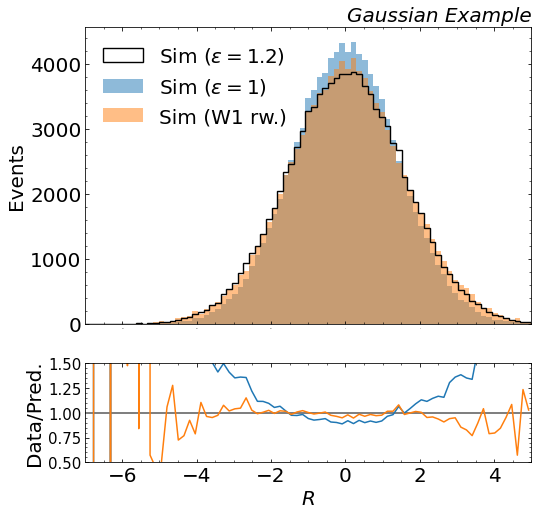

<Figure size 432x288 with 0 Axes>

In [32]:
# Test the trained W1 model

epsilon_test = 1.2
theta_test = (epsilon_test-epsilon_sim)/delta_epsilon
T_test = np.random.normal(mu_sim,sigma_sim,Ntest).reshape(-1, 1)
R_test0 = np.random.normal(T_test+beta_sim,epsilon_sim)
R_test1 = np.random.normal(T_test+beta_sim,epsilon_test)

w1_test_ds = w0_dataset(T_test, R_test0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1RT_model_network, w1T_model_network, theta_test)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-7, 5, 80, xlabel=r"$R$", density=False)
cpwr.add_data(R_test1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0, label="Sim (W1 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

In [33]:
# Generate data for W0 training (as well as theta)

Ndata = 100000
Nsim = 200000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0.2
sigma_data = 1
beta_data = 0
epsilon_data = 1.2

# simulation
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim).reshape(-1, 1)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)

# data
T_data = np.random.normal(mu_data,sigma_data,Ndata).reshape(-1, 1)
R_data = np.random.normal(T_data+beta_data,epsilon_data)

In [34]:
# Load W1 model and convert data into W0 datasets and data loaders
w0_ds = w0_dataset(T_sim, R_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(R_sim.mean(axis=0)).to(dvc),
    torch.from_numpy(R_sim.std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets
w0_ds_train, w0_ds_test = random_split(w0_ds, [len(w0_ds)//2, len(w0_ds)-len(w0_ds)//2])#, generator=torch.Generator().manual_seed(42))
w0_dataloader_train = DataLoader(w0_ds_train, batch_size=len(w0_ds_train), shuffle=True, num_workers=12)
w0_dataloader_test = DataLoader(w0_ds_test, batch_size=len(w0_ds_test), shuffle=False, num_workers=12)

[0.0015683914456866017, 0.9990591908952969, tensor([0.0020], device='cuda:0', dtype=torch.float64), tensor([1.4130], device='cuda:0', dtype=torch.float64)]


In [35]:
# Create W0 model and train it (also theta)!

w0_model_network = w0_network(sigmoid=False, std_params=std_params).double().to(dvc)
theta_model = theta_module(0.).to(dvc)

ml = nn.ModuleList()
ml.append(w0_model_network)
ml.append(theta_model)

optimizer = optim.Adam(ml.parameters(), lr=0.001)

loss_fn = NLLLoss(R_data, np.linspace(-5,5,20), normalize=False, device=dvc)

w0_tr = w0_trainer(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1RT_model_network, w1T_model_network, theta_model, loss_fn, optimizer)
w0_tr.fit()

===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1RT =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=3, out_features=50, bias=True)
    (relu_0): ReLU()
    (batchNorm_0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (batchNorm_1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (linear_2): Linear(in_features=50, ou

[Epoch  63] [Train_loss: -799502.040734] [Val_loss: -799525.693576] [Theta: 0.0505625419318676]
[Epoch  64] [Train_loss: -799500.566966] [Val_loss: -799524.028190] [Theta: 0.05082247406244278]
[Epoch  65] [Train_loss: -799499.287782] [Val_loss: -799522.702756] [Theta: 0.05105986446142197]
[Epoch  66] [Train_loss: -799498.426762] [Val_loss: -799522.025877] [Theta: 0.0512755922973156]
[Epoch  67] [Train_loss: -799497.595254] [Val_loss: -799521.467618] [Theta: 0.0514708086848259]
[Epoch  68] [Train_loss: -799496.692604] [Val_loss: -799520.670280] [Theta: 0.05164685100317001]
[Epoch  69] [Train_loss: -799496.141900] [Val_loss: -799519.875792] [Theta: 0.051805101335048676]
[Epoch  70] [Train_loss: -799496.140235] [Val_loss: -799519.311545] [Theta: 0.051946889609098434]
[Epoch  71] [Train_loss: -799496.439709] [Val_loss: -799518.965563] [Theta: 0.052073489874601364]
[Epoch  72] [Train_loss: -799496.924843] [Val_loss: -799519.025268] [Theta: 0.05218616500496864]
[Epoch  73] [Train_loss: -7994

1.0402235805988311
[Test_loss: -799526.732207]


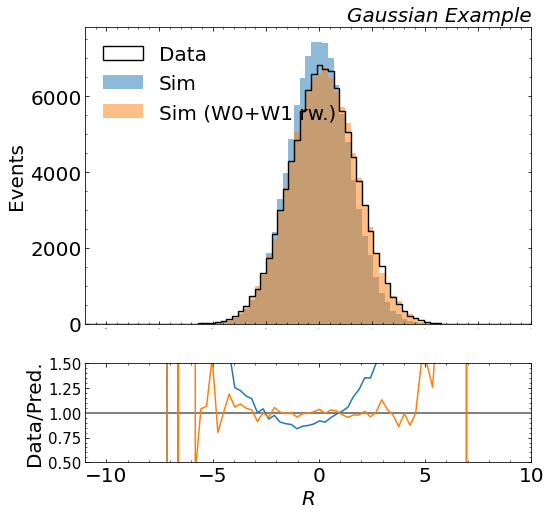

<Figure size 432x288 with 0 Axes>

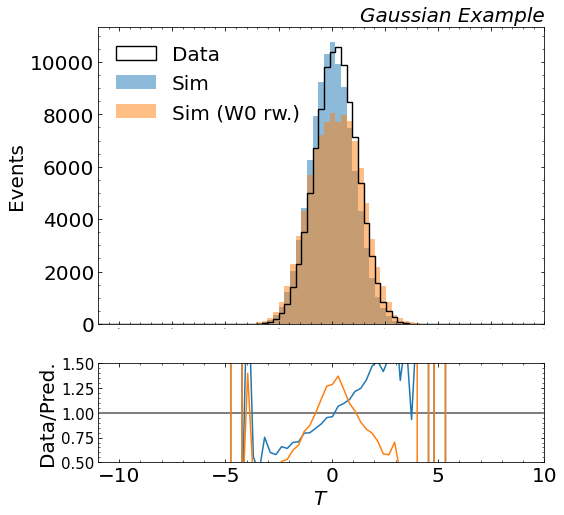

<Figure size 432x288 with 0 Axes>

In [36]:
# Test the trained W0 model and fitted theta

print(theta_model().item()*0.8+1)

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network, w1RT_model_network, w1T_model_network, theta_model, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$R$", density=False)
cpwr.add_data(R_data[:,0], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=Ws_0, label="Sim (W0+W1 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$T$", density=False)
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (W0 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

# Gaussian 2D example --- 1D particle-level + 2D detector-level

- t ∼ N (μ, σ)
- r|t ∼ N (t + β, ε)
- r'|t ∼ N (t + β', ε')

ε considered as the nuisance parameter

σ fixed to 1

β, β' fixed to 0

ε' fixed to 1

In [38]:
# Generate toy data for W1 training

Nsim = 200000
Ntest = 100000

# simulation
mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1
betap_sim = 0
epsilonp_sim = 1
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim).reshape(-1, 1)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)
Rp_sim = np.random.normal(T_sim+betap_sim,epsilonp_sim)

# simulation with theta variation (theta value randomly sampled)
epsilon0_sim = np.random.uniform(0.2, 1.8, Nsim).reshape(-1, 1)
epsilon1_sim = np.random.uniform(0.2, 1.8, Nsim).reshape(-1, 1) # used for training
delta_epsilon = 0.8
# delta_epsilon = 0.2
theta0_sim = (epsilon0_sim-epsilon_sim)/delta_epsilon
theta1_sim = (epsilon1_sim-epsilon_sim)/delta_epsilon
R1_sim = []
for i in range(Nsim):
    # use the same T_sim for R_sim variation
    R1_sim.append(np.random.normal(T_sim[i]+beta_sim, epsilon1_sim[i,0]))
R1_sim = np.array(R1_sim)
Rp1_sim = np.random.normal(T_sim+betap_sim,epsilonp_sim)

In [39]:
# Convert data into W1 dataset, data loaders

Rs_sim = np.concatenate((R_sim, Rp_sim), axis=1)
Rs1_sim = np.concatenate((R1_sim, Rp1_sim), axis=1)

w1_ds = w1_dataset(T_sim, Rs_sim, theta0_sim, T_sim, Rs1_sim, theta1_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(np.concatenate((Rs_sim, Rs1_sim)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((Rs_sim, Rs1_sim)).std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])#, generator=torch.Generator().manual_seed(42))
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=100000, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=100000, shuffle=False, num_workers=12)

[-0.0033220851972709698, 1.0003261107503891, tensor([-0.0023, -0.0043], device='cuda:0', dtype=torch.float64), tensor([1.4528, 1.4127], device='cuda:0', dtype=torch.float64)]


In [40]:
# Create W1 model and train it!

w1RT_model_network = w1RT_network(sigmoid=True, std_params=std_params, n_inputs=4).double().to(dvc)
optimizerRT = optim.Adam(w1RT_model_network.parameters(), lr=0.001)
loss_fn_RT = nn.BCELoss()
w1RT_tr = w1_trainer(w1_dataloader_train, w1_dataloader_test, w1RT_model_network, loss_fn_RT, optimizerRT)

w1T_model_network = w1T_network(sigmoid=True, std_params=std_params, n_inputs=2).double().to(dvc)
optimizerT = optim.Adam(w1T_model_network.parameters(), lr=0.001)
loss_fn_T = nn.BCELoss()
w1T_tr = w1_trainer(w1_dataloader_train, w1_dataloader_test, w1T_model_network, loss_fn_T, optimizerT)

w1RT_tr.fit()
w1T_tr.fit()

===================== Model W1 =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (batchNorm_0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (batchNorm_1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (batchNorm_2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
===================== Model W1 =====================
w1T_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=2, out_features=50, bias=True)
    (relu_0): ReLU()
    (b

[Epoch  71] [Train_loss: 0.635167 Train_auc: 0.664674] [Val_loss: 0.637727 Val_auc: 0.659750]
[Epoch  72] [Train_loss: 0.635177 Train_auc: 0.664643] [Val_loss: 0.637730 Val_auc: 0.659668]
[Epoch  73] [Train_loss: 0.635103 Train_auc: 0.664709] [Val_loss: 0.637693 Val_auc: 0.659664]
[Epoch  74] [Train_loss: 0.635006 Train_auc: 0.664835] [Val_loss: 0.637660 Val_auc: 0.659708]
[Epoch  75] [Train_loss: 0.634978 Train_auc: 0.664868] [Val_loss: 0.637670 Val_auc: 0.659691]
[Epoch  76] [Train_loss: 0.634967 Train_auc: 0.664879] [Val_loss: 0.637682 Val_auc: 0.659665]
[Epoch  77] [Train_loss: 0.634877 Train_auc: 0.664942] [Val_loss: 0.637604 Val_auc: 0.659710]
[Epoch  78] [Train_loss: 0.634787 Train_auc: 0.665009] [Val_loss: 0.637549 Val_auc: 0.659716]
[Epoch  79] [Train_loss: 0.634766 Train_auc: 0.665037] [Val_loss: 0.637555 Val_auc: 0.659704]
[Epoch  80] [Train_loss: 0.634733 Train_auc: 0.665154] [Val_loss: 0.637533 Val_auc: 0.659781]
[Epoch  81] [Train_loss: 0.634747 Train_auc: 0.665101] [Val_

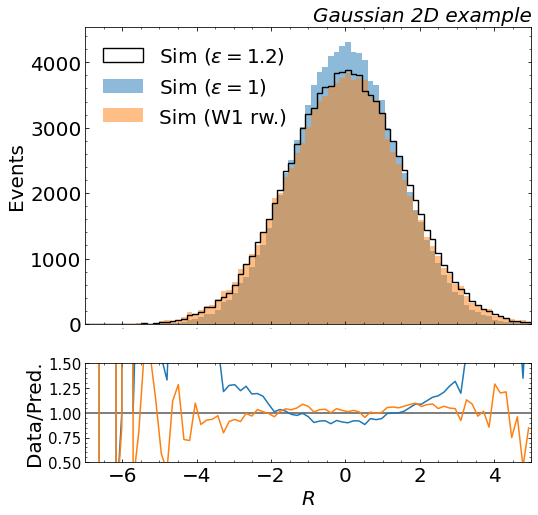

<Figure size 432x288 with 0 Axes>

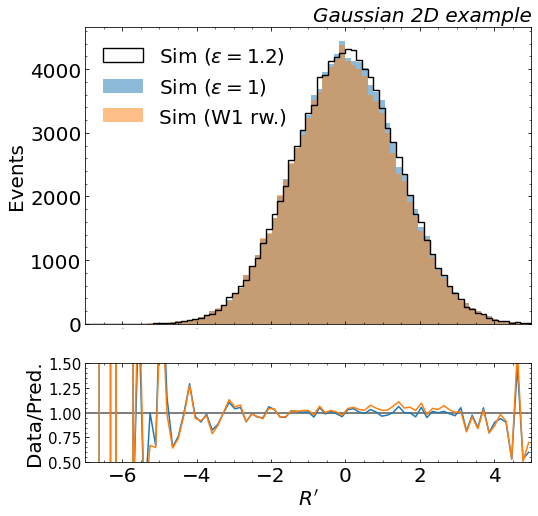

<Figure size 432x288 with 0 Axes>

In [41]:
# Test the trained W1 model

epsilon_test = 1.2
theta_test = (epsilon_test-epsilon_sim)/delta_epsilon
T_test = np.random.normal(mu_sim,sigma_sim,Ntest).reshape(-1, 1)
R_test0 = np.random.normal(T_test+beta_sim,epsilon_sim)
Rp_test0 = np.random.normal(T_test+betap_sim,epsilonp_sim)
R_test1 = np.random.normal(T_test+beta_sim,epsilon_test)
Rp_test1 = np.random.normal(T_test+betap_sim,epsilonp_sim)

Rs_test0 = np.concatenate((R_test0, Rp_test0), axis=1)
w1_test_ds = w0_dataset(T_test, Rs_test0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1RT_model_network, w1T_model_network, theta_test)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-7, 5, 80, xlabel=r"$R$", density=False, header="Gaussian 2D example")
cpwr.add_data(R_test1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0, label="Sim (W1 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-7, 5, 80, xlabel=r"$R^\prime$", density=False, header="Gaussian 2D example")
cpwr.add_data(Rp_test1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=W1s_0, label="Sim (W1 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

In [43]:
# Generate data for W0 training (as well as theta)

Ndata = 100000
Nsim = 200000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1
betap_sim = 0
epsilonp_sim = 1

mu_data = 0.8
sigma_data = 1
beta_data = 0
epsilon_data = 1.2
betap_data = 0
epsilonp_data = 1

# simulation
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim).reshape(-1, 1)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)
Rp_sim = np.random.normal(T_sim+betap_sim,epsilonp_sim)

# data
T_data = np.random.normal(mu_data,sigma_data,Ndata).reshape(-1, 1)
R_data = np.random.normal(T_data+beta_data,epsilon_data)
Rp_data = np.random.normal(T_data+betap_data,epsilonp_data)

In [48]:
# Convert data into W0 datasets and data loaders
Rs_sim = np.concatenate((R_sim, Rp_sim), axis=1)
w0_ds = w0_dataset(T_sim, Rs_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(R_sim.mean(axis=0)).to(dvc),
    torch.from_numpy(R_sim.std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w0_ds_train, w0_ds_test = random_split(w0_ds, [len(w0_ds)//2, len(w0_ds)-len(w0_ds)//2])#, generator=torch.Generator().manual_seed(42))
w0_dataloader_train = DataLoader(w0_ds_train, batch_size=len(w0_ds_train), shuffle=True, num_workers=12)
w0_dataloader_test = DataLoader(w0_ds_test, batch_size=len(w0_ds_test), shuffle=False, num_workers=12)

[-0.001875832941217523, 0.9956352802156696, tensor([-0.0045], device='cuda:0', dtype=torch.float64), tensor([1.4127], device='cuda:0', dtype=torch.float64)]


In [49]:
# Create W0 model and train it (also theta)!

w0_model_network = w0_network(sigmoid=False, std_params=std_params).double().to(dvc)
theta_model = theta_module(0.).to(dvc)

ml = nn.ModuleList()
ml.append(w0_model_network)
ml.append(theta_model)

optimizer = optim.Adam(ml.parameters(), lr=0.001)

Rs_data = np.concatenate((R_data, Rp_data), axis=1)
loss_fn = NLLLoss_2D(Rs_data, np.linspace(-5,5,20), np.linspace(-5,5,20), device=dvc)

w0_tr = w0_trainer(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1RT_model_network, w1T_model_network, theta_model, loss_fn, optimizer)
w0_tr.fit(n_epoch=10000)

===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1RT =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (batchNorm_0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (batchNorm_1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (linear_2): Linear(in_features=50, ou

[Epoch  63] [Train_loss: -567766.649060] [Val_loss: -567870.884287] [Theta: 0.05943111702799797]
[Epoch  64] [Train_loss: -567778.095592] [Val_loss: -567886.633779] [Theta: 0.06022953987121582]
[Epoch  65] [Train_loss: -567789.059001] [Val_loss: -567900.262441] [Theta: 0.061021849513053894]
[Epoch  66] [Train_loss: -567798.631412] [Val_loss: -567910.956476] [Theta: 0.06180839240550995]
[Epoch  67] [Train_loss: -567804.716914] [Val_loss: -567917.359911] [Theta: 0.0625893697142601]
[Epoch  68] [Train_loss: -567807.814046] [Val_loss: -567920.804760] [Theta: 0.06336507946252823]
[Epoch  69] [Train_loss: -567810.833910] [Val_loss: -567924.833362] [Theta: 0.06413576751947403]
[Epoch  70] [Train_loss: -567815.582815] [Val_loss: -567931.329790] [Theta: 0.0649016723036766]
[Epoch  71] [Train_loss: -567821.243550] [Val_loss: -567939.024355] [Theta: 0.06566318869590759]
[Epoch  72] [Train_loss: -567826.721030] [Val_loss: -567946.129127] [Theta: 0.06642064452171326]
[Epoch  73] [Train_loss: -56783

[Epoch 147] [Train_loss: -568211.135271] [Val_loss: -568279.871366] [Theta: 0.11700611561536789]
[Epoch 148] [Train_loss: -568214.439882] [Val_loss: -568282.845780] [Theta: 0.11759588122367859]
[Epoch 149] [Train_loss: -568217.713523] [Val_loss: -568285.789331] [Theta: 0.11818337440490723]
[Epoch 150] [Train_loss: -568220.950565] [Val_loss: -568288.687161] [Theta: 0.11876858025789261]
[Epoch 151] [Train_loss: -568224.150569] [Val_loss: -568291.534104] [Theta: 0.11935141682624817]
[Epoch 152] [Train_loss: -568227.318820] [Val_loss: -568294.334859] [Theta: 0.11993192136287689]
[Epoch 153] [Train_loss: -568230.453585] [Val_loss: -568297.104292] [Theta: 0.12051010131835938]
[Epoch 154] [Train_loss: -568233.551565] [Val_loss: -568299.860662] [Theta: 0.12108595669269562]
[Epoch 155] [Train_loss: -568236.611743] [Val_loss: -568302.600062] [Theta: 0.12165939807891846]
[Epoch 156] [Train_loss: -568239.637108] [Val_loss: -568305.310057] [Theta: 0.12223032861948013]
[Epoch 157] [Train_loss: -5682

[Epoch 231] [Train_loss: -568397.546152] [Val_loss: -568439.469846] [Theta: 0.15909989178180695]
[Epoch 232] [Train_loss: -568398.905975] [Val_loss: -568440.580681] [Theta: 0.1595153957605362]
[Epoch 233] [Train_loss: -568400.249591] [Val_loss: -568441.677268] [Theta: 0.15992885828018188]
[Epoch 234] [Train_loss: -568401.577895] [Val_loss: -568442.761374] [Theta: 0.16034026443958282]
[Epoch 235] [Train_loss: -568402.891289] [Val_loss: -568443.830336] [Theta: 0.1607496291399002]
[Epoch 236] [Train_loss: -568404.191397] [Val_loss: -568444.884470] [Theta: 0.1611570119857788]
[Epoch 237] [Train_loss: -568405.476901] [Val_loss: -568445.927424] [Theta: 0.1615624576807022]
[Epoch 238] [Train_loss: -568406.746842] [Val_loss: -568446.948011] [Theta: 0.16196592152118683]
[Epoch 239] [Train_loss: -568408.000623] [Val_loss: -568447.952545] [Theta: 0.16236740350723267]
[Epoch 240] [Train_loss: -568409.239998] [Val_loss: -568448.944474] [Theta: 0.16276688873767853]
[Epoch 241] [Train_loss: -568410.4

[Epoch 315] [Train_loss: -568470.164776] [Val_loss: -568495.838012] [Theta: 0.1875201314687729]
[Epoch 316] [Train_loss: -568470.639069] [Val_loss: -568496.132883] [Theta: 0.18778619170188904]
[Epoch 317] [Train_loss: -568471.125928] [Val_loss: -568496.390135] [Theta: 0.18805080652236938]
[Epoch 318] [Train_loss: -568471.617710] [Val_loss: -568496.653906] [Theta: 0.1883140355348587]
[Epoch 319] [Train_loss: -568472.109893] [Val_loss: -568496.949587] [Theta: 0.1885758936405182]
[Epoch 320] [Train_loss: -568472.599263] [Val_loss: -568497.263203] [Theta: 0.18883639574050903]
[Epoch 321] [Train_loss: -568473.062729] [Val_loss: -568497.568451] [Theta: 0.18909557163715363]
[Epoch 322] [Train_loss: -568473.511716] [Val_loss: -568497.909104] [Theta: 0.18935348093509674]
[Epoch 323] [Train_loss: -568473.970503] [Val_loss: -568498.277892] [Theta: 0.18961016833782196]
[Epoch 324] [Train_loss: -568474.436841] [Val_loss: -568498.663277] [Theta: 0.18986564874649048]
[Epoch 325] [Train_loss: -568474.

[Epoch 399] [Train_loss: -568495.514648] [Val_loss: -568513.411368] [Theta: 0.20526258647441864]
[Epoch 400] [Train_loss: -568495.676741] [Val_loss: -568513.478786] [Theta: 0.20542095601558685]
[Epoch 401] [Train_loss: -568495.812157] [Val_loss: -568513.548142] [Theta: 0.20557817816734314]
[Epoch 402] [Train_loss: -568495.960900] [Val_loss: -568513.667375] [Theta: 0.2057342529296875]
[Epoch 403] [Train_loss: -568496.122646] [Val_loss: -568513.806284] [Theta: 0.20588919520378113]
[Epoch 404] [Train_loss: -568496.278917] [Val_loss: -568513.936302] [Theta: 0.20604300498962402]
[Epoch 405] [Train_loss: -568496.419153] [Val_loss: -568514.014143] [Theta: 0.20619569718837738]
[Epoch 406] [Train_loss: -568496.559715] [Val_loss: -568514.104870] [Theta: 0.2063472718000412]
[Epoch 407] [Train_loss: -568496.701893] [Val_loss: -568514.224611] [Theta: 0.20649775862693787]
[Epoch 408] [Train_loss: -568496.844423] [Val_loss: -568514.323646] [Theta: 0.20664718747138977]
[Epoch 409] [Train_loss: -568496

[Epoch 483] [Train_loss: -568503.512843] [Val_loss: -568517.654578] [Theta: 0.2154875248670578]
[Epoch 484] [Train_loss: -568503.561918] [Val_loss: -568517.638383] [Theta: 0.21557700634002686]
[Epoch 485] [Train_loss: -568503.610157] [Val_loss: -568517.589945] [Theta: 0.21566574275493622]
[Epoch 486] [Train_loss: -568503.658876] [Val_loss: -568517.602231] [Theta: 0.2157537341117859]
[Epoch 487] [Train_loss: -568503.707610] [Val_loss: -568517.660538] [Theta: 0.21584099531173706]
[Epoch 488] [Train_loss: -568503.751538] [Val_loss: -568517.689014] [Theta: 0.2159276008605957]
[Epoch 489] [Train_loss: -568503.797314] [Val_loss: -568517.681284] [Theta: 0.21601353585720062]
[Epoch 490] [Train_loss: -568503.833197] [Val_loss: -568517.663572] [Theta: 0.2160988748073578]
[Epoch 491] [Train_loss: -568503.888655] [Val_loss: -568517.726232] [Theta: 0.216183602809906]
[Epoch 492] [Train_loss: -568503.932230] [Val_loss: -568517.778856] [Theta: 0.21626770496368408]
[Epoch 493] [Train_loss: -568503.973

[Epoch 567] [Train_loss: -568505.960340] [Val_loss: -568518.374269] [Theta: 0.2210828959941864]
Early stopping! Restore state at epoch 556.
[Best_val_loss: -568518.410146]
Fitted theta: 0.2210828959941864


Fitted epsilon = 1.1764262914657593
[Test_loss: -568518.410146]


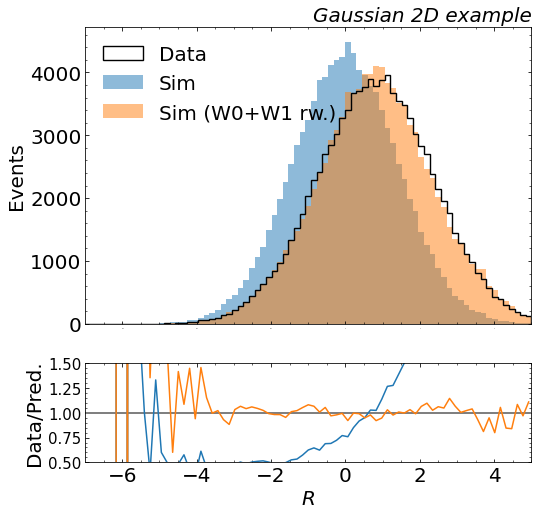

<Figure size 432x288 with 0 Axes>

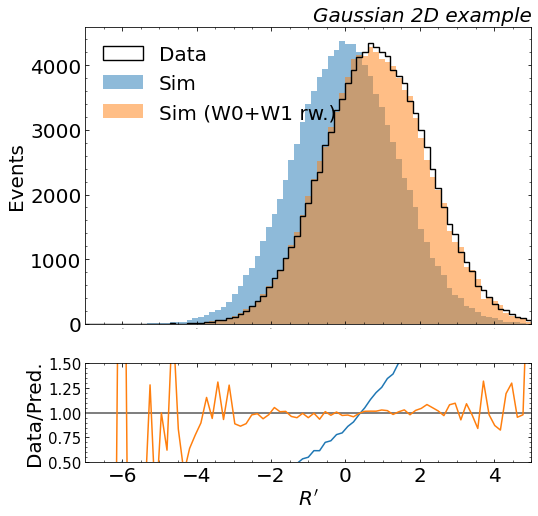

<Figure size 432x288 with 0 Axes>

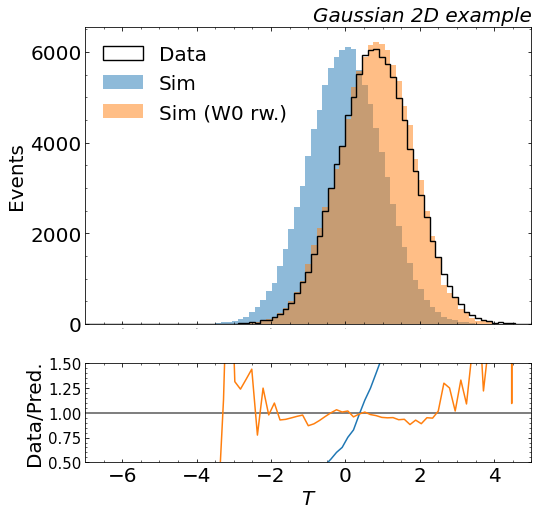

<Figure size 432x288 with 0 Axes>

In [52]:
# Test the trained W0 model and fitted theta

print(f"Fitted epsilon = {theta_model().item()*delta_epsilon+1}")

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network, w1RT_model_network, w1T_model_network, theta_model, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-7, 5, 80, xlabel=r"$R$", density=False, header="Gaussian 2D example")
cpwr.add_data(Rs_data[:,0], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=Ws_0, label="Sim (W0+W1 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-7, 5, 80, xlabel=r"$R^\prime$", density=False, header="Gaussian 2D example")
cpwr.add_data(Rs_data[:,1], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=Ws_0, label="Sim (W0+W1 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-7, 5, 80, xlabel=r"$T$", density=False, header="Gaussian 2D example")
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (W0 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

# Physics example --- Higgs cross-section measurement

- Particle-level observable: Higgs pT
- Detector-level observables: diphoton pT, diphoton invariant mass
- Nuisance parameter: photon detector resolution

In [53]:
# Download physics datasets

!wget https://zenodo.org/record/7553271/files/processed_madgraph_2j_1.0_1000000.npz
!wget https://zenodo.org/record/7553271/files/processed_madgraph_2j_1.2_1000000.npz
!wget https://zenodo.org/record/7553271/files/processed_madgraph_2j_syst_1000000.npz
!wget https://zenodo.org/record/7553271/files/processed_powheg_2j_1.2_200000.npz

--2023-01-20 23:46:54--  https://zenodo.org/record/7553271/files/processed_madgraph_2j_1.0_1000000.npz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27564363 (26M) [application/octet-stream]
Saving to: ‘processed_madgraph_2j_1.0_1000000.npz.3’

100%[======================================>] 27,564,363  52.1MB/s   in 0.5s   

2023-01-20 23:46:56 (52.1 MB/s) - ‘processed_madgraph_2j_1.0_1000000.npz.3’ saved [27564363/27564363]

--2023-01-20 23:46:56--  https://zenodo.org/record/7553271/files/processed_madgraph_2j_1.2_1000000.npz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27582446 (26M) [application/octet-stream]
Saving to: ‘processed_madgraph_2j_1.2_1000000.npz.3’

100%[======================================>] 27,582,446   1

In [56]:
# Convert data into W1 dataset, data loaders

madgraph_0 = np.load("processed_madgraph_2j_1.0_1000000.npz")
madgraph_syst = np.load("processed_madgraph_2j_syst_1000000.npz")

nEvents = min(len(madgraph_0["T_Ptyy"]), len(madgraph_syst["T_Ptyy"]))
print(f"Restrict to {nEvents} events.")

T_sim_0 = madgraph_0["T_Ptyy"][:nEvents].reshape(-1, 1)
T_sim_1 = madgraph_syst["T_Ptyy"][:nEvents].reshape(-1, 1)

R_Ptyy_sim_0 = madgraph_0["R_Ptyy"][:nEvents].reshape(-1, 1)
R_Ptyy_sim_1 = madgraph_syst["R_Ptyy"][:nEvents].reshape(-1, 1)

R_myy_sim_0 = madgraph_0["R_myy"][:nEvents].reshape(-1, 1)
R_myy_sim_1 = madgraph_syst["R_myy"][:nEvents].reshape(-1, 1)

Delta_epsilon = 0.5
theta_sim_0 = ((np.array(list(np.linspace(0.5,1.49,100))*10000)-1.0)/Delta_epsilon).reshape(-1, 1) # discrete
np.random.shuffle(theta_sim_0)
theta_sim_0 = theta_sim_0[:nEvents]
theta_sim_1 = ((madgraph_syst["Theta"].astype(float)-1.0)/Delta_theta).reshape(-1, 1)

R_sim_0 = np.concatenate([R_Ptyy_sim_0, R_myy_sim_0], axis=1)
R_sim_1 = np.concatenate([R_Ptyy_sim_1, R_myy_sim_1], axis=1)

w1_ds = w1_dataset(T_sim_0, R_sim_0, theta_sim_0, T_sim_1, R_sim_1, theta_sim_1)
std_params = [
    torch.from_numpy(np.concatenate((T_sim_0, T_sim_1)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((T_sim_0, T_sim_1)).std(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((R_sim_0, R_sim_1)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((R_sim_0, R_sim_1)).std(axis=0)).to(dvc)
]
print(std_params)

# split samples to 50% train and 50% test sets
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=100000, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=100000, shuffle=False, num_workers=12)

Restrict to 920045 events.
[tensor([108.9107], device='cuda:0', dtype=torch.float64), tensor([87.8341], device='cuda:0', dtype=torch.float64), tensor([102.8705, 131.7401], device='cuda:0', dtype=torch.float64), tensor([81.8296, 73.0375], device='cuda:0', dtype=torch.float64)]


In [57]:
# Create W1 model and training it!

w1RT_model_network = w1RT_network(sigmoid=True, std_params=std_params, n_inputs=4).double().to(dvc)
optimizerRT = optim.Adam(w1RT_model_network.parameters(), lr=0.001)
loss_fn_RT = nn.BCELoss()
w1RT_tr = w1_trainer(w1_dataloader_train, w1_dataloader_test, w1RT_model_network, loss_fn_RT, optimizerRT, patience=20)

w1T_model_network = w1T_network(sigmoid=True, std_params=std_params, n_inputs=2).double().to(dvc)
optimizerT = optim.Adam(w1T_model_network.parameters(), lr=0.001)
loss_fn_T = nn.BCELoss()
w1T_tr = w1_trainer(w1_dataloader_train, w1_dataloader_test, w1T_model_network, loss_fn_T, optimizerT)

w1RT_tr.fit()
w1T_tr.fit()

===================== Model W1 =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (batchNorm_0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (batchNorm_1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (batchNorm_2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
===================== Model W1 =====================
w1T_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=2, out_features=50, bias=True)
    (relu_0): ReLU()
    (b

[Epoch  71] [Train_loss: 0.688160 Train_auc: 0.552601] [Val_loss: 0.688708 Val_auc: 0.549021]
[Epoch  72] [Train_loss: 0.687760 Train_auc: 0.554895] [Val_loss: 0.688260 Val_auc: 0.551059]
[Epoch  73] [Train_loss: 0.688099 Train_auc: 0.552885] [Val_loss: 0.688581 Val_auc: 0.549179]
[Epoch  74] [Train_loss: 0.688016 Train_auc: 0.553166] [Val_loss: 0.688433 Val_auc: 0.549681]
[Epoch  75] [Train_loss: 0.687770 Train_auc: 0.554660] [Val_loss: 0.688267 Val_auc: 0.550995]
[Epoch  76] [Train_loss: 0.687840 Train_auc: 0.554626] [Val_loss: 0.688322 Val_auc: 0.550846]
[Epoch  77] [Train_loss: 0.687805 Train_auc: 0.554148] [Val_loss: 0.688347 Val_auc: 0.550148]
[Epoch  78] [Train_loss: 0.687583 Train_auc: 0.555598] [Val_loss: 0.688110 Val_auc: 0.551684]
[Epoch  79] [Train_loss: 0.687763 Train_auc: 0.554231] [Val_loss: 0.688345 Val_auc: 0.550344]
[Epoch  80] [Train_loss: 0.687934 Train_auc: 0.553205] [Val_loss: 0.688385 Val_auc: 0.549388]
[Epoch  81] [Train_loss: 0.687939 Train_auc: 0.553789] [Val_

[Epoch 158] [Train_loss: 0.686634 Train_auc: 0.558633] [Val_loss: 0.687501 Val_auc: 0.553531]
[Epoch 159] [Train_loss: 0.686572 Train_auc: 0.558400] [Val_loss: 0.687290 Val_auc: 0.554097]
[Epoch 160] [Train_loss: 0.686388 Train_auc: 0.559458] [Val_loss: 0.687227 Val_auc: 0.554408]
[Epoch 161] [Train_loss: 0.686809 Train_auc: 0.557262] [Val_loss: 0.687433 Val_auc: 0.552840]
[Epoch 162] [Train_loss: 0.686514 Train_auc: 0.558766] [Val_loss: 0.687227 Val_auc: 0.553982]
[Epoch 163] [Train_loss: 0.685963 Train_auc: 0.560945] [Val_loss: 0.686699 Val_auc: 0.556254]
[Epoch 164] [Train_loss: 0.686000 Train_auc: 0.561209] [Val_loss: 0.686802 Val_auc: 0.555992]
[Epoch 165] [Train_loss: 0.685937 Train_auc: 0.561319] [Val_loss: 0.686682 Val_auc: 0.556403]
[Epoch 166] [Train_loss: 0.686124 Train_auc: 0.560637] [Val_loss: 0.686834 Val_auc: 0.555964]
[Epoch 167] [Train_loss: 0.686246 Train_auc: 0.560163] [Val_loss: 0.686935 Val_auc: 0.555430]
[Epoch 168] [Train_loss: 0.686332 Train_auc: 0.559857] [Val_

[Epoch 245] [Train_loss: 0.684976 Train_auc: 0.565979] [Val_loss: 0.686038 Val_auc: 0.559386]
[Epoch 246] [Train_loss: 0.685501 Train_auc: 0.563981] [Val_loss: 0.686472 Val_auc: 0.557414]
[Epoch 247] [Train_loss: 0.685243 Train_auc: 0.564592] [Val_loss: 0.686129 Val_auc: 0.559071]
[Epoch 248] [Train_loss: 0.685303 Train_auc: 0.564658] [Val_loss: 0.686328 Val_auc: 0.558668]
[Epoch 249] [Train_loss: 0.685072 Train_auc: 0.565572] [Val_loss: 0.686003 Val_auc: 0.559646]
[Epoch 250] [Train_loss: 0.685095 Train_auc: 0.565569] [Val_loss: 0.686126 Val_auc: 0.559157]
[Epoch 251] [Train_loss: 0.684973 Train_auc: 0.566010] [Val_loss: 0.685956 Val_auc: 0.559724]
[Epoch 252] [Train_loss: 0.684776 Train_auc: 0.566950] [Val_loss: 0.685757 Val_auc: 0.560707]
[Epoch 253] [Train_loss: 0.684887 Train_auc: 0.566204] [Val_loss: 0.685822 Val_auc: 0.560076]
[Epoch 254] [Train_loss: 0.684819 Train_auc: 0.566681] [Val_loss: 0.685898 Val_auc: 0.560103]
[Epoch 255] [Train_loss: 0.685155 Train_auc: 0.565217] [Val_

Restrict to 919849 events.


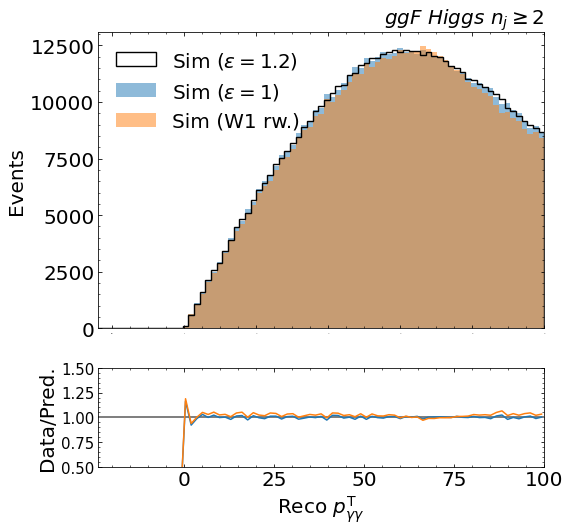

<Figure size 432x288 with 0 Axes>

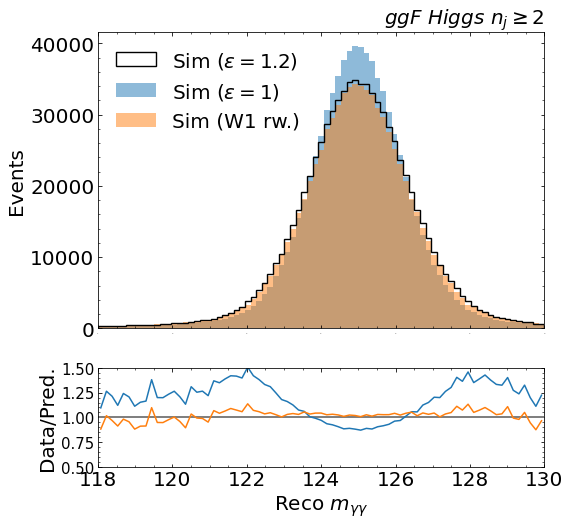

<Figure size 432x288 with 0 Axes>

In [64]:
# Test the trained W1 model
madgraph_1 = np.load("processed_madgraph_2j_1.2_1000000.npz")
theta_test = (1.2-1.0)/Delta_theta

nEvents = min(len(madgraph_0["T_Ptyy"]), len(madgraph_1["T_Ptyy"]))
print(f"Restrict to {nEvents} events.")

T_test_0 = madgraph_0["T_Ptyy"][:nEvents].reshape(-1, 1)
T_test_1 = madgraph_1["T_Ptyy"][:nEvents].reshape(-1, 1)

R_Ptyy_test_0 = madgraph_0["R_Ptyy"][:nEvents].reshape(-1, 1)
R_Ptyy_test_1 = madgraph_1["R_Ptyy"][:nEvents].reshape(-1, 1)

R_myy_test_0 = madgraph_0["R_myy"][:nEvents].reshape(-1, 1)
R_myy_test_1 = madgraph_1["R_myy"][:nEvents].reshape(-1, 1)

R_test_0 = np.concatenate([R_Ptyy_test_0, R_myy_test_0], axis=1)
R_test_1 = np.concatenate([R_Ptyy_test_1, R_myy_test_1], axis=1)

w1_test_ds = w0_dataset(T_test_0, R_test_0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=100000, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1RT_model_network, w1T_model_network, theta_test)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-24, 100, 80, xlabel=r"Reco $p^\mathrm{T}_{\gamma\gamma}$", density=False, header="ggF Higgs $n_j \geq 2$")
cpwr.add_data(R_Ptyy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0[:,0], label="Sim (W1 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(118, 130, 80, xlabel=r"Reco $m_{\gamma\gamma}$", density=False, header="ggF Higgs $n_j \geq 2$")
cpwr.add_data(R_myy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=W1s_0[:,0], label="Sim (W1 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

In [65]:
# Now convert data into W0 datasets and data loaders

powheg = np.load("processed_powheg_2j_1.2_200000.npz")
madgraph = np.load("processed_madgraph_2j_1.0_1000000.npz")

nEvents = min(len(powheg["T_Ptyy"]), len(madgraph["T_Ptyy"]))
print(f"Restrict to {nEvents} events.")

T_sim = madgraph["T_Ptyy"][:nEvents].reshape(-1, 1)
T_data = powheg["T_Ptyy"][:nEvents].reshape(-1, 1)

R_Ptyy_sim = madgraph["R_Ptyy"][:nEvents].reshape(-1, 1)
R_Ptyy_data = powheg["R_Ptyy"][:nEvents].reshape(-1, 1)

R_myy_sim = madgraph["R_myy"][:nEvents].reshape(-1, 1)
R_myy_data = powheg["R_myy"][:nEvents].reshape(-1, 1)

R_sim = np.concatenate([R_Ptyy_sim, R_myy_sim], axis=1)
R_data = np.concatenate([R_Ptyy_data, R_myy_data], axis=1)

w0_ds = w0_dataset(T_sim, R_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(R_sim.mean(axis=0)).to(dvc),
    torch.from_numpy(R_sim.std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w0_ds_train, w0_ds_test = random_split(w0_ds, [len(w0_ds)//2, len(w0_ds)-len(w0_ds)//2])#, generator=torch.Generator().manual_seed(42))
w0_dataloader_train = DataLoader(w0_ds_train, batch_size=len(w0_ds_train), shuffle=True, num_workers=12)
w0_dataloader_test = DataLoader(w0_ds_test, batch_size=len(w0_ds_test), shuffle=False, num_workers=12)

Restrict to 92328 events.
[108.78174383271597, 87.19179055675701, tensor([102.8734, 131.7648], device='cuda:0', dtype=torch.float64), tensor([81.1856, 73.4087], device='cuda:0', dtype=torch.float64)]


In [66]:
# Create W0 model and train it (also theta)!

w0_model_network = w0_network(sigmoid=False, std_params=std_params).double().to(dvc)
theta_model = theta_module(0.).to(dvc)

ml = nn.ModuleList()
ml.append(w0_model_network)
ml.append(theta_model)

optimizer = optim.Adam(ml.parameters(), lr=0.0005)

loss_fn = NLLLoss_2D(R_data, np.linspace(0,200,201), np.linspace(110,140,31), device=dvc)

w0_tr = w0_trainer(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1RT_model_network, w1T_model_network, theta_model, loss_fn, optimizer)
w0_tr.fit(n_epoch=10000)

===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1RT =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (batchNorm_0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (batchNorm_1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (linear_2): Linear(in_features=50, ou

[Epoch  63] [Train_loss: -247110.706230] [Val_loss: -247030.146066] [Theta: 0.029479390010237694]
[Epoch  64] [Train_loss: -247181.995947] [Val_loss: -247098.374051] [Theta: 0.029891300946474075]
[Epoch  65] [Train_loss: -247250.171541] [Val_loss: -247162.859856] [Theta: 0.030301840975880623]
[Epoch  66] [Train_loss: -247316.222245] [Val_loss: -247224.686253] [Theta: 0.030711093917489052]
[Epoch  67] [Train_loss: -247380.582736] [Val_loss: -247284.469249] [Theta: 0.03111903741955757]
[Epoch  68] [Train_loss: -247442.820927] [Val_loss: -247341.985205] [Theta: 0.0315256230533123]
[Epoch  69] [Train_loss: -247501.346610] [Val_loss: -247395.956469] [Theta: 0.03193053975701332]
[Epoch  70] [Train_loss: -247555.524284] [Val_loss: -247445.651261] [Theta: 0.0323336161673069]
[Epoch  71] [Train_loss: -247603.171905] [Val_loss: -247489.709682] [Theta: 0.032734908163547516]
[Epoch  72] [Train_loss: -247643.907411] [Val_loss: -247526.711151] [Theta: 0.03313450142741203]
[Epoch  73] [Train_loss: -2

[Epoch 147] [Train_loss: -248272.404193] [Val_loss: -248084.808189] [Theta: 0.06285403668880463]
[Epoch 148] [Train_loss: -248275.064384] [Val_loss: -248087.097989] [Theta: 0.06330827623605728]
[Epoch 149] [Train_loss: -248277.726629] [Val_loss: -248089.416402] [Theta: 0.06376384198665619]
[Epoch 150] [Train_loss: -248280.396243] [Val_loss: -248091.779409] [Theta: 0.06422095000743866]
[Epoch 151] [Train_loss: -248283.073465] [Val_loss: -248094.190962] [Theta: 0.06467947363853455]
[Epoch 152] [Train_loss: -248285.761962] [Val_loss: -248096.633330] [Theta: 0.0651395171880722]
[Epoch 153] [Train_loss: -248288.458294] [Val_loss: -248099.103850] [Theta: 0.06560098379850388]
[Epoch 154] [Train_loss: -248291.156885] [Val_loss: -248101.588579] [Theta: 0.06606405228376389]
[Epoch 155] [Train_loss: -248293.842167] [Val_loss: -248104.086553] [Theta: 0.06652844697237015]
[Epoch 156] [Train_loss: -248296.522402] [Val_loss: -248106.586945] [Theta: 0.06699374318122864]
[Epoch 157] [Train_loss: -24829

[Epoch 231] [Train_loss: -248500.520011] [Val_loss: -248301.785575] [Theta: 0.10360190272331238]
[Epoch 232] [Train_loss: -248503.084283] [Val_loss: -248304.146094] [Theta: 0.10408894717693329]
[Epoch 233] [Train_loss: -248505.636884] [Val_loss: -248306.501553] [Theta: 0.10457558929920197]
[Epoch 234] [Train_loss: -248508.179098] [Val_loss: -248308.844216] [Theta: 0.10506166517734528]
[Epoch 235] [Train_loss: -248510.708521] [Val_loss: -248311.178934] [Theta: 0.10554715991020203]
[Epoch 236] [Train_loss: -248513.222718] [Val_loss: -248313.509086] [Theta: 0.10603190213441849]
[Epoch 237] [Train_loss: -248515.726522] [Val_loss: -248315.828537] [Theta: 0.10651589930057526]
[Epoch 238] [Train_loss: -248518.217050] [Val_loss: -248318.137996] [Theta: 0.10699908435344696]
[Epoch 239] [Train_loss: -248520.695655] [Val_loss: -248320.438359] [Theta: 0.10748147964477539]
[Epoch 240] [Train_loss: -248523.154340] [Val_loss: -248322.736477] [Theta: 0.10796289891004562]
[Epoch 241] [Train_loss: -2485

[Epoch 315] [Train_loss: -248663.433401] [Val_loss: -248454.190588] [Theta: 0.14000821113586426]
[Epoch 316] [Train_loss: -248664.737097] [Val_loss: -248455.427577] [Theta: 0.14037302136421204]
[Epoch 317] [Train_loss: -248666.026958] [Val_loss: -248456.663929] [Theta: 0.14073655009269714]
[Epoch 318] [Train_loss: -248667.299523] [Val_loss: -248457.905389] [Theta: 0.1410985141992569]
[Epoch 319] [Train_loss: -248668.564042] [Val_loss: -248459.144624] [Theta: 0.1414589285850525]
[Epoch 320] [Train_loss: -248669.821453] [Val_loss: -248460.374632] [Theta: 0.14181798696517944]
[Epoch 321] [Train_loss: -248671.068040] [Val_loss: -248461.591766] [Theta: 0.14217567443847656]
[Epoch 322] [Train_loss: -248672.306369] [Val_loss: -248462.793083] [Theta: 0.1425320953130722]
[Epoch 323] [Train_loss: -248673.533507] [Val_loss: -248463.980473] [Theta: 0.1428871601819992]
[Epoch 324] [Train_loss: -248674.752472] [Val_loss: -248465.159895] [Theta: 0.14324097335338593]
[Epoch 325] [Train_loss: -248675.9

[Epoch 400] [Train_loss: -248750.452421] [Val_loss: -248538.311210] [Theta: 0.16777178645133972]
[Epoch 401] [Train_loss: -248751.310483] [Val_loss: -248539.136915] [Theta: 0.16807930171489716]
[Epoch 402] [Train_loss: -248752.163496] [Val_loss: -248539.950817] [Theta: 0.16838614642620087]
[Epoch 403] [Train_loss: -248753.006015] [Val_loss: -248540.754497] [Theta: 0.16869212687015533]
[Epoch 404] [Train_loss: -248753.842101] [Val_loss: -248541.553573] [Theta: 0.16899719834327698]
[Epoch 405] [Train_loss: -248754.672309] [Val_loss: -248542.338450] [Theta: 0.1693013608455658]
[Epoch 406] [Train_loss: -248755.498403] [Val_loss: -248543.121622] [Theta: 0.1696045845746994]
[Epoch 407] [Train_loss: -248756.319733] [Val_loss: -248543.905812] [Theta: 0.16990700364112854]
[Epoch 408] [Train_loss: -248757.135315] [Val_loss: -248544.686699] [Theta: 0.17020855844020844]
[Epoch 409] [Train_loss: -248757.946583] [Val_loss: -248545.455300] [Theta: 0.1705092340707779]
[Epoch 410] [Train_loss: -248758.

[Epoch 484] [Train_loss: -248810.923181] [Val_loss: -248593.034024] [Theta: 0.19181372225284576]
[Epoch 485] [Train_loss: -248811.559396] [Val_loss: -248593.567230] [Theta: 0.19208924472332]
[Epoch 486] [Train_loss: -248812.188908] [Val_loss: -248594.099147] [Theta: 0.19236412644386292]
[Epoch 487] [Train_loss: -248812.815828] [Val_loss: -248594.625470] [Theta: 0.1926383525133133]
[Epoch 488] [Train_loss: -248813.441053] [Val_loss: -248595.146224] [Theta: 0.19291196763515472]
[Epoch 489] [Train_loss: -248814.068143] [Val_loss: -248595.663097] [Theta: 0.19318512082099915]
[Epoch 490] [Train_loss: -248814.695174] [Val_loss: -248596.173998] [Theta: 0.19345805048942566]
[Epoch 491] [Train_loss: -248815.322287] [Val_loss: -248596.683329] [Theta: 0.19373072683811188]
[Epoch 492] [Train_loss: -248815.949129] [Val_loss: -248597.199721] [Theta: 0.19400332868099213]
[Epoch 493] [Train_loss: -248816.572592] [Val_loss: -248597.710619] [Theta: 0.1942756474018097]
[Epoch 494] [Train_loss: -248817.19

[Epoch 568] [Train_loss: -248857.589075] [Val_loss: -248631.357270] [Theta: 0.2136782556772232]
[Epoch 569] [Train_loss: -248858.094717] [Val_loss: -248631.755173] [Theta: 0.2139294594526291]
[Epoch 570] [Train_loss: -248858.600803] [Val_loss: -248632.154159] [Theta: 0.21418072283267975]
[Epoch 571] [Train_loss: -248859.107683] [Val_loss: -248632.545920] [Theta: 0.21443207561969757]
[Epoch 572] [Train_loss: -248859.614754] [Val_loss: -248632.935043] [Theta: 0.21468353271484375]
[Epoch 573] [Train_loss: -248860.119936] [Val_loss: -248633.320001] [Theta: 0.2149350941181183]
[Epoch 574] [Train_loss: -248860.623055] [Val_loss: -248633.710373] [Theta: 0.21518656611442566]
[Epoch 575] [Train_loss: -248861.123184] [Val_loss: -248634.107504] [Theta: 0.2154379040002823]
[Epoch 576] [Train_loss: -248861.619875] [Val_loss: -248634.506020] [Theta: 0.21568895876407623]
[Epoch 577] [Train_loss: -248862.113101] [Val_loss: -248634.904390] [Theta: 0.21593964099884033]
[Epoch 578] [Train_loss: -248862.6

[Epoch 652] [Train_loss: -248897.456830] [Val_loss: -248662.646396] [Theta: 0.23436497151851654]
[Epoch 653] [Train_loss: -248897.921824] [Val_loss: -248663.004115] [Theta: 0.2346092015504837]
[Epoch 654] [Train_loss: -248898.387258] [Val_loss: -248663.361961] [Theta: 0.23485369980335236]
[Epoch 655] [Train_loss: -248898.851792] [Val_loss: -248663.721642] [Theta: 0.23509837687015533]
[Epoch 656] [Train_loss: -248899.317174] [Val_loss: -248664.079629] [Theta: 0.23534323275089264]
[Epoch 657] [Train_loss: -248899.784017] [Val_loss: -248664.435221] [Theta: 0.23558835685253143]
[Epoch 658] [Train_loss: -248900.249422] [Val_loss: -248664.796063] [Theta: 0.2358337789773941]
[Epoch 659] [Train_loss: -248900.711857] [Val_loss: -248665.160308] [Theta: 0.23607927560806274]
[Epoch 660] [Train_loss: -248901.172392] [Val_loss: -248665.530680] [Theta: 0.2363247126340866]
[Epoch 661] [Train_loss: -248901.632959] [Val_loss: -248665.901362] [Theta: 0.2365700751543045]
[Epoch 662] [Train_loss: -248902.0

[Epoch 736] [Train_loss: -248936.128455] [Val_loss: -248691.629743] [Theta: 0.2553067207336426]
[Epoch 737] [Train_loss: -248936.591162] [Val_loss: -248691.985947] [Theta: 0.25556322932243347]
[Epoch 738] [Train_loss: -248937.054618] [Val_loss: -248692.322163] [Theta: 0.255819708108902]
[Epoch 739] [Train_loss: -248937.516975] [Val_loss: -248692.657476] [Theta: 0.2560761868953705]
[Epoch 740] [Train_loss: -248937.980190] [Val_loss: -248693.005076] [Theta: 0.25633272528648376]
[Epoch 741] [Train_loss: -248938.443392] [Val_loss: -248693.368563] [Theta: 0.25658929347991943]
[Epoch 742] [Train_loss: -248938.907913] [Val_loss: -248693.725587] [Theta: 0.2568458616733551]
[Epoch 743] [Train_loss: -248939.373470] [Val_loss: -248694.075700] [Theta: 0.25710269808769226]
[Epoch 744] [Train_loss: -248939.836598] [Val_loss: -248694.423760] [Theta: 0.25735968351364136]
[Epoch 745] [Train_loss: -248940.298800] [Val_loss: -248694.754756] [Theta: 0.25761672854423523]
[Epoch 746] [Train_loss: -248940.75

[Epoch 821] [Train_loss: -248972.138093] [Val_loss: -248719.251882] [Theta: 0.27650341391563416]
[Epoch 822] [Train_loss: -248972.542221] [Val_loss: -248719.559371] [Theta: 0.27674785256385803]
[Epoch 823] [Train_loss: -248972.946398] [Val_loss: -248719.894016] [Theta: 0.27699264883995056]
[Epoch 824] [Train_loss: -248973.348704] [Val_loss: -248720.230168] [Theta: 0.2772376537322998]
[Epoch 825] [Train_loss: -248973.751704] [Val_loss: -248720.561378] [Theta: 0.277482807636261]
[Epoch 826] [Train_loss: -248974.153694] [Val_loss: -248720.882388] [Theta: 0.2777280807495117]
[Epoch 827] [Train_loss: -248974.554825] [Val_loss: -248721.202967] [Theta: 0.2779734134674072]
[Epoch 828] [Train_loss: -248974.954531] [Val_loss: -248721.520902] [Theta: 0.27821874618530273]
[Epoch 829] [Train_loss: -248975.354179] [Val_loss: -248721.845629] [Theta: 0.2784639894962311]
[Epoch 830] [Train_loss: -248975.754609] [Val_loss: -248722.173283] [Theta: 0.2787092626094818]
[Epoch 831] [Train_loss: -248976.1565

[Epoch 906] [Train_loss: -249005.881207] [Val_loss: -248746.641262] [Theta: 0.297333687543869]
[Epoch 907] [Train_loss: -249006.272587] [Val_loss: -248746.957970] [Theta: 0.29758086800575256]
[Epoch 908] [Train_loss: -249006.664167] [Val_loss: -248747.266599] [Theta: 0.29782813787460327]
[Epoch 909] [Train_loss: -249007.054598] [Val_loss: -248747.563317] [Theta: 0.29807549715042114]
[Epoch 910] [Train_loss: -249007.443507] [Val_loss: -248747.849928] [Theta: 0.298322856426239]
[Epoch 911] [Train_loss: -249007.832350] [Val_loss: -248748.128548] [Theta: 0.2985702455043793]
[Epoch 912] [Train_loss: -249008.219934] [Val_loss: -248748.420305] [Theta: 0.29881763458251953]
[Epoch 913] [Train_loss: -249008.605198] [Val_loss: -248748.727256] [Theta: 0.29906490445137024]
[Epoch 914] [Train_loss: -249008.991108] [Val_loss: -248749.032973] [Theta: 0.29931193590164185]
[Epoch 915] [Train_loss: -249009.377646] [Val_loss: -248749.334620] [Theta: 0.29955899715423584]
[Epoch 916] [Train_loss: -249009.76

[Epoch 991] [Train_loss: -249036.575878] [Val_loss: -248770.232441] [Theta: 0.3179394602775574]
[Epoch 992] [Train_loss: -249036.898221] [Val_loss: -248770.494306] [Theta: 0.31817203760147095]
[Epoch 993] [Train_loss: -249037.218723] [Val_loss: -248770.753281] [Theta: 0.31840428709983826]
[Epoch 994] [Train_loss: -249037.538383] [Val_loss: -248770.997476] [Theta: 0.3186362087726593]
[Epoch 995] [Train_loss: -249037.856214] [Val_loss: -248771.222139] [Theta: 0.31886765360832214]
[Epoch 996] [Train_loss: -249038.172929] [Val_loss: -248771.440146] [Theta: 0.31909871101379395]
[Epoch 997] [Train_loss: -249038.490624] [Val_loss: -248771.684358] [Theta: 0.31932953000068665]
[Epoch 998] [Train_loss: -249038.809562] [Val_loss: -248771.948368] [Theta: 0.31956011056900024]
[Epoch 999] [Train_loss: -249039.126012] [Val_loss: -248772.204102] [Theta: 0.3197905719280243]
[Epoch 1000] [Train_loss: -249039.440636] [Val_loss: -248772.434058] [Theta: 0.32002073526382446]
[Epoch 1001] [Train_loss: -24903

[Epoch 1075] [Train_loss: -249059.382130] [Val_loss: -248787.313696] [Theta: 0.33600056171417236]
[Epoch 1076] [Train_loss: -249059.611473] [Val_loss: -248787.498018] [Theta: 0.33619749546051025]
[Epoch 1077] [Train_loss: -249059.839994] [Val_loss: -248787.708557] [Theta: 0.3363943099975586]
[Epoch 1078] [Train_loss: -249060.066122] [Val_loss: -248787.895181] [Theta: 0.33659106492996216]
[Epoch 1079] [Train_loss: -249060.294762] [Val_loss: -248788.021182] [Theta: 0.3367878496646881]
[Epoch 1080] [Train_loss: -249060.522958] [Val_loss: -248788.125528] [Theta: 0.33698463439941406]
[Epoch 1081] [Train_loss: -249060.749313] [Val_loss: -248788.269008] [Theta: 0.33718129992485046]
[Epoch 1082] [Train_loss: -249060.975497] [Val_loss: -248788.473848] [Theta: 0.3373779058456421]
[Epoch 1083] [Train_loss: -249061.202093] [Val_loss: -248788.679633] [Theta: 0.33757442235946655]
[Epoch 1084] [Train_loss: -249061.427500] [Val_loss: -248788.854283] [Theta: 0.3377707898616791]
[Epoch 1085] [Train_loss

[Epoch 1159] [Train_loss: -249077.314835] [Val_loss: -248799.161994] [Theta: 0.35215675830841064]
[Epoch 1160] [Train_loss: -249077.508339] [Val_loss: -248799.313510] [Theta: 0.35234013199806213]
[Epoch 1161] [Train_loss: -249077.700505] [Val_loss: -248799.465892] [Theta: 0.3525233864784241]
[Epoch 1162] [Train_loss: -249077.891737] [Val_loss: -248799.588623] [Theta: 0.3527064919471741]
[Epoch 1163] [Train_loss: -249078.082118] [Val_loss: -248799.685999] [Theta: 0.3528892993927002]
[Epoch 1164] [Train_loss: -249078.271481] [Val_loss: -248799.793637] [Theta: 0.35307183861732483]
[Epoch 1165] [Train_loss: -249078.458097] [Val_loss: -248799.941592] [Theta: 0.3532539904117584]
[Epoch 1166] [Train_loss: -249078.643688] [Val_loss: -248800.096003] [Theta: 0.35343557596206665]
[Epoch 1167] [Train_loss: -249078.828417] [Val_loss: -248800.225869] [Theta: 0.35361674427986145]
[Epoch 1168] [Train_loss: -249079.011017] [Val_loss: -248800.324836] [Theta: 0.35379746556282043]
[Epoch 1169] [Train_loss

[Epoch 1243] [Train_loss: -249090.552531] [Val_loss: -248807.413712] [Theta: 0.3661530315876007]
[Epoch 1244] [Train_loss: -249090.684119] [Val_loss: -248807.458552] [Theta: 0.3663051426410675]
[Epoch 1245] [Train_loss: -249090.815081] [Val_loss: -248807.518326] [Theta: 0.36645710468292236]
[Epoch 1246] [Train_loss: -249090.945723] [Val_loss: -248807.610160] [Theta: 0.3666088879108429]
[Epoch 1247] [Train_loss: -249091.076381] [Val_loss: -248807.706795] [Theta: 0.3667604923248291]
[Epoch 1248] [Train_loss: -249091.205435] [Val_loss: -248807.781399] [Theta: 0.36691179871559143]
[Epoch 1249] [Train_loss: -249091.333724] [Val_loss: -248807.831846] [Theta: 0.3670627474784851]
[Epoch 1250] [Train_loss: -249091.462430] [Val_loss: -248807.897983] [Theta: 0.36721348762512207]
[Epoch 1251] [Train_loss: -249091.591191] [Val_loss: -248807.981992] [Theta: 0.3673640787601471]
[Epoch 1252] [Train_loss: -249091.720508] [Val_loss: -248808.070903] [Theta: 0.36751461029052734]
[Epoch 1253] [Train_loss: 

[Epoch 1327] [Train_loss: -249100.475680] [Val_loss: -248812.764321] [Theta: 0.3784025311470032]
[Epoch 1328] [Train_loss: -249100.575139] [Val_loss: -248812.824574] [Theta: 0.37853899598121643]
[Epoch 1329] [Train_loss: -249100.674754] [Val_loss: -248812.830074] [Theta: 0.37867504358291626]
[Epoch 1330] [Train_loss: -249100.773968] [Val_loss: -248812.834565] [Theta: 0.3788107633590698]
[Epoch 1331] [Train_loss: -249100.873356] [Val_loss: -248812.893244] [Theta: 0.3789462149143219]
[Epoch 1332] [Train_loss: -249100.974063] [Val_loss: -248812.989700] [Theta: 0.3790816366672516]
[Epoch 1333] [Train_loss: -249101.074554] [Val_loss: -248813.042675] [Theta: 0.3792169988155365]
[Epoch 1334] [Train_loss: -249101.174356] [Val_loss: -248813.037622] [Theta: 0.37935227155685425]
[Epoch 1335] [Train_loss: -249101.273200] [Val_loss: -248813.035005] [Theta: 0.37948745489120483]
[Epoch 1336] [Train_loss: -249101.371162] [Val_loss: -248813.087041] [Theta: 0.37962237000465393]
[Epoch 1337] [Train_loss:

[Epoch 1411] [Train_loss: -249107.806411] [Val_loss: -248815.751860] [Theta: 0.3890887498855591]
[Epoch 1412] [Train_loss: -249107.872805] [Val_loss: -248815.733793] [Theta: 0.389199435710907]
[Epoch 1413] [Train_loss: -249107.940535] [Val_loss: -248815.779420] [Theta: 0.3893100619316101]
[Epoch 1414] [Train_loss: -249108.007366] [Val_loss: -248815.838608] [Theta: 0.3894205391407013]
[Epoch 1415] [Train_loss: -249108.072379] [Val_loss: -248815.848313] [Theta: 0.38953083753585815]
[Epoch 1416] [Train_loss: -249108.137430] [Val_loss: -248815.835131] [Theta: 0.3896408677101135]
[Epoch 1417] [Train_loss: -249108.204095] [Val_loss: -248815.851844] [Theta: 0.38975057005882263]
[Epoch 1418] [Train_loss: -249108.269110] [Val_loss: -248815.893495] [Theta: 0.38986027240753174]
[Epoch 1419] [Train_loss: -249108.334864] [Val_loss: -248815.938810] [Theta: 0.38997000455856323]
[Epoch 1420] [Train_loss: -249108.402111] [Val_loss: -248815.963882] [Theta: 0.3900798559188843]
[Epoch 1421] [Train_loss: -

Fitted epsilon = 1.1982918679714203
[Test_loss: -248816.864800]


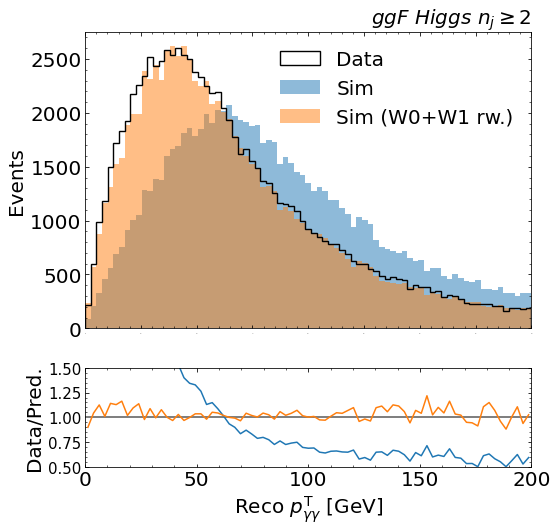

<Figure size 432x288 with 0 Axes>

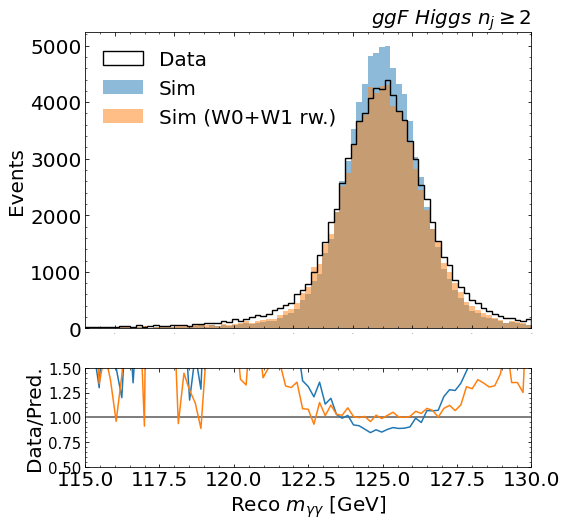

<Figure size 432x288 with 0 Axes>

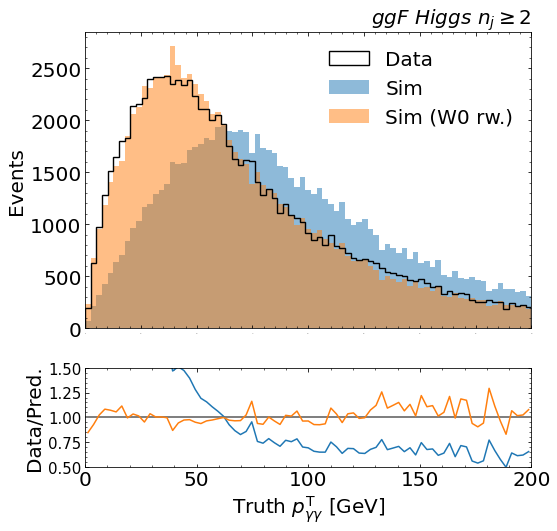

<Figure size 432x288 with 0 Axes>

In [73]:
# Test the trained W0 model and fitted theta value

print(f"Fitted epsilon = {theta_model().item()*Delta_epsilon+1}")

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network, w1RT_model_network, w1T_model_network, theta_model, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(0, 200, 80, xlabel=r"Reco $p^\mathrm{T}_{\gamma\gamma}$ [GeV]", density=False, legend_corner="upper right", header=r"ggF Higgs $n_j \geq 2$")
cpwr.add_data(R_Ptyy_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:, 0], weights=Rs_0[:, 0]*2/Rs_0[:, 0], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:, 0], weights=Ws_0, label="Sim (W0+W1 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(115, 130, 80, xlabel=r"Reco $m_{\gamma\gamma}$ [GeV]", density=False, header=r"ggF Higgs $n_j \geq 2$")
cpwr.add_data(R_myy_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:, 1], weights=Rs_0[:, 1]*2/Rs_0[:, 1], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:, 1], weights=Ws_0, label="Sim (W0+W1 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 200, 80, xlabel=r"Truth $p^\mathrm{T}_{\gamma\gamma}$ [GeV]", density=False, legend_corner="upper right", header=r"ggF Higgs $n_j \geq 2$")
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, weights=Ts_0*2/Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (W0 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()